In [1]:
import numba
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pywavefront
import os
from pathlib import Path
import time
import numba
import math
import pyvista as pv

In [2]:
from LightTransportSimulator.light_transport.src.vectors import *

In [3]:
from LightTransportSimulator.light_transport.src.scene import Scene, Light
from LightTransportSimulator.light_transport.src.primitives import Triangle, PreComputedTriangle
from LightTransportSimulator.light_transport.src.cornell_box import get_cornell_box, get_floor
from LightTransportSimulator.light_transport.examples.obj.glass import design_glass
from LightTransportSimulator.light_transport.src.colors import *
from LightTransportSimulator.light_transport.src.render import render_scene

In [4]:
# get object
objects = numba.typed.List()
start_id = 0
triangles, points = design_glass(start_id)
points = np.ascontiguousarray(points)

In [5]:
#set scene depths

xmax, ymax, zmax = points.max(axis=0)
xmin, ymin, zmin = points.min(axis=0)

padding = 15
depth = abs(max(xmax, ymax, zmax)) + padding
x_depth = abs(xmax) + 10
y_depth = abs(ymax) + 1
z_depth = abs(zmax) + 10
xmax, ymax, zmax, depth

(7.0, 12.5, 7.0, 27.5)

In [6]:
#setup cornell box

surface_color = WHITE_2
left_wall_color = RED
right_wall_color = GREEN

surface_mat = Material(color=surface_color, shininess=90, reflection=0.1, ior=1.5210, transmission=0.1) # calcium sulphate
left_wall_mat = Material(color=left_wall_color, shininess=90, reflection=0.1, ior=1.5210, transmission=0.1)
right_wall_mat = Material(color=right_wall_color, shininess=90, reflection=0.1, ior=1.5210, transmission=0.1)

start_id = len(triangles)
# objects = get_floor(x_depth, y_depth, z_depth, surface_mat, start_id)
objects = get_cornell_box(depth, surface_mat, left_wall_mat, right_wall_mat, start_id)

xmin, ymin, zmin = -depth, -depth, depth
xmax, ymax, zmax = depth, depth, -depth

objects

ListType[instance.jitclass.PreComputedTriangle#27810e88dc0<type:int64,id:int64,vertex_1:array(float64, 1d, C),vertex_2:array(float64, 1d, C),vertex_3:array(float64, 1d, C),centroid:array(float64, 1d, C),material:instance.jitclass.Material#278135ca4a0<color:instance.jitclass.Color#278135c8bb0<ambient:array(float64, 1d, A),diffuse:array(float64, 1d, A),specular:array(float64, 1d, A)>,shininess:float64,reflection:float64,ior:float64,is_mirror:bool,transmission:float64>,is_light:bool,edge_1:array(float64, 1d, C),edge_2:array(float64, 1d, C),normal:array(float64, 1d, C),num:float64,transformation:array(float64, 2d, A)>]([<numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x0000027817FD3160>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x0000027817FD3E20>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x0000027817FD3160>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x0000027817FD3E20>, <numba.experimental.jitclass

In [7]:
#setup loaded objects

id = len(objects)+1
for t in triangles:
    objects.append(t)

len(objects), id

(2576, 17)

In [35]:
# global light source

source_mat = Material(color=WHITE, shininess=1, reflection=0.9, ior=1.5)

l_x = 1
l_y = depth+0.1
l_z = 1

id = len(objects)+1

light_1 = PreComputedTriangle(id=id,
                   vertex_1=np.array([-l_x, l_y, -l_z, 1], dtype=np.float64),
                   vertex_2=np.array([l_x, l_y, l_z, 1], dtype=np.float64),
                   vertex_3=np.array([-l_x, l_y, l_z, 1], dtype=np.float64),
                   material=source_mat,
                   is_light=True)
id += 1

light_2 = PreComputedTriangle(id=id,
                   vertex_1=np.array([l_x, l_y, l_z, 1], dtype=np.float64),
                   vertex_2=np.array([-l_x, l_y, -l_z, 1], dtype=np.float64),
                   vertex_3=np.array([l_x, l_y, -l_z, 1], dtype=np.float64),
                   material=source_mat,
                   is_light=True)


light_samples = 1
a = np.random.uniform(0,1,light_samples)
b = np.random.uniform(1,0,light_samples)

light_sources = numba.typed.List()

for x in range(light_samples):
    tp1 = light_1.vertex_1 * (1-math.sqrt(a[x])) + light_1.vertex_2 * (math.sqrt(a[x])*(1-b[x])) + light_1.vertex_3 * (b[x]*math.sqrt(a[x]))
    l1 = Light(source=tp1, material=source_mat)
    light_sources.append(l1)
    tp2 = light_2.vertex_1 * (1-math.sqrt(a[x])) + light_2.vertex_2 * (math.sqrt(a[x])*(1-b[x])) + light_2.vertex_3 * (b[x]*math.sqrt(a[x]))
    l2 = Light(source=tp1, material=source_mat)
    light_sources.append(l2)
    print(tp1, tp2)

light_sources

[ 0.40308106 27.6         0.5725146   1.        ] [-0.40308106 27.6        -0.5725146   1.        ]


ListType[instance.jitclass.Light#253ea7e0d00<source:array(float64, 1d, A),material:instance.jitclass.Material#253ee6898a0<color:instance.jitclass.Color#253ee647430<ambient:array(float64, 1d, A),diffuse:array(float64, 1d, A),specular:array(float64, 1d, A)>,shininess:float64,reflection:float64,ior:float64,is_mirror:bool,transmission:float64>>]([<numba.experimental.jitclass.boxing.Light object at 0x00000253F30C3580>, <numba.experimental.jitclass.boxing.Light object at 0x00000253F30C2D70>, ...])

In [36]:
objects.append(light_1)
objects.append(light_2)

In [8]:
# point source
light_sources = numba.typed.List()
source_mat = Material(color=WHITE, shininess=1, reflection=0.9, ior=1.5)
l1 = Light(source=np.array([3, 5, 3, 1], dtype=np.float64), material=source_mat)
light_sources.append(l1)

In [9]:
# setup scene

#camera
camera = np.array([0, 0, depth+0.5, 1], dtype=np.float64)

#screen
width=100
height=100
max_depth=3

#scene
scene = Scene(camera=camera, lights=light_sources, width=width, height=height, max_depth=max_depth, depth=depth)

In [10]:
from LightTransportSimulator.light_transport.src.primitives import AABB
# min_point=np.array([scene.left, scene.bottom, -scene.depth], dtype=np.float64)
# max_point=np.array([scene.right, scene.top, scene.depth], dtype=np.float64)
min_point=np.array([xmin, ymin, zmin], dtype=np.float64)
max_point=np.array([xmax, ymax, zmax], dtype=np.float64)
box = AABB(min_point=min_point, max_point=max_point)
box

In [11]:
from LightTransportSimulator.light_transport.src.bvh import BVH

bvh = BVH()
bvh.insert(objects, box)

In [12]:
# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
image = render_scene(scene, bvh.top)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Elapsed (with compilation) = 873.2635717391968


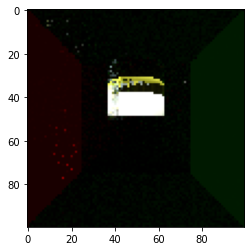

In [13]:
plt.imshow(image)